In [1]:
import ee
import geemap
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score,mean_absolute_percentage_error
import glob
import dask.dataframe as dd
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [2]:
Map_S5P = geemap.Map()
Map_S5P

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [3]:
# Create a common region of interest
roi = ee.Geometry.Polygon([[[-123.28736502403991,36.53106212747138],
        [-120.57374197716491,36.53106212747138],
        [-120.57374197716491,38.629116592353306],
        [-123.28736502403991,38.629116592353306],
        [-123.28736502403991,36.53106212747138]]])

In [4]:
# Data COllection for July
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_S1_SR = ee.ImageCollection("COPERNICUS/S1_GRD") \
  .filterBounds(roi) \
  .filterDate('2018-07-01', '2018-07-31'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S1_bands = ['HH','HV','VH','VV']
bands=['HH','HV','VH','VV']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S1_SR = image_S1_SR.median().select(S1_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S1_display = {'bands': bands, 'min': 0, 'max': 0.3}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S1_SR, S1_display, 'Sentinel-S2_SR')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)

EEException: Image.select: Pattern 'HH' did not match any bands.

In [5]:
Map_S5P_sep = geemap.Map()
Map_S5P_sep

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [6]:
# Data COllection for September
image_S5P_sep = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P_sep = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P_sep.addLayer(image_S5P_sep, vis_params_S5P_sep, "Sentinel-5P TROPOMI NO2")

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_S2_SR_sep = ee.ImageCollection("COPERNICUS/S2") \
  .filterBounds(roi) \
  .filterDate('2018-09-01', '2018-09-30'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9', 'B11', 'B12']
bands=['B4', 'B3', 'B2']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S2_SR_sep = image_S2_SR_sep.median().select(S2_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S2_display = {'bands': bands, 'min': 0, 'max': 3000}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S2_SR_sep, S2_display, 'Sentinel-S2_SR_sep')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)


In [22]:
#traing data for July
ground_truth= image_S2_SR.addBands(image_S5P)

# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 10,
    'numPixels': 2000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [8]:
#traing data for September
ground_truth_sep= image_S2_SR_sep.addBands(image_S5P)

# Make the training dataset.
points_sep = ground_truth_sep.sample(**{
    'region': ground_truth_sep.geometry(),
    'scale': 10,
    'numPixels': 2000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P_sep.addLayer(points_sep, {}, 'training', False)

In [13]:
df = geemap.ee_to_pandas(points)
df

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,NO2_column_number_density
0,1355.0,2306.0,1396.0,1134.0,1193.5,933.5,1356.0,2883.5,3306.0,3094.5,3489.0,809.5,0.000093
1,1162.0,1516.0,888.0,924.0,823.0,748.0,991.0,1561.0,1827.0,1743.0,2010.0,601.0,0.000088
2,1445.0,1315.5,1005.5,1106.5,961.0,879.5,996.0,1063.0,1179.0,807.0,1149.5,500.0,0.000101
3,1382.0,3739.5,2279.0,1382.5,1481.0,2060.0,2114.0,2466.0,2833.0,2835.5,3295.0,1031.0,0.000092
4,4821.5,4091.5,2921.5,4561.0,4237.5,4435.5,4343.5,4448.0,4624.0,4358.5,4707.5,1390.0,0.000063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1466.0,3684.5,1981.5,1440.5,1619.0,2301.5,2527.5,2980.0,3354.5,3363.5,3914.5,1151.0,0.000106
996,1241.0,2247.0,1021.5,1039.5,1080.0,798.5,1315.5,3098.0,3885.0,3751.5,4256.5,1043.0,0.000098
997,1214.0,3067.5,1740.0,1185.5,1243.5,1689.5,1843.0,2109.0,2406.5,2410.5,2750.5,869.5,0.000089
998,1302.0,2543.0,1881.0,1127.5,1099.0,1299.0,1254.5,1569.5,1809.5,1790.5,2048.5,624.5,0.000093


In [154]:
df_sep = geemap.ee_to_pandas(points_sep)
df_sep

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,NO2_column_number_density
0,1544.0,2266.0,1934.0,1328.5,1216.0,1293.0,1326.5,1416.5,1543.0,1515.0,1678.5,521.5,0.000093
1,1151.5,1431.5,808.0,874.5,706.5,643.5,916.0,1424.0,1655.0,1657.0,1879.0,736.0,0.000088
2,1401.0,1056.0,895.0,921.0,711.0,557.0,775.0,762.0,835.0,471.0,825.0,652.0,0.000101
3,1410.5,3783.5,2302.5,1407.5,1557.0,2213.0,2316.5,2544.5,2916.5,3127.5,3483.0,1411.0,0.000092
4,4336.0,4164.5,3596.5,3903.5,3720.5,4004.0,3886.0,4009.0,4189.5,3829.0,4351.5,1522.0,0.000063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1102.0,1699.5,879.5,905.5,795.5,692.0,977.0,1895.0,2253.5,2259.5,2523.5,889.5,0.000097
496,1427.5,1783.5,1354.0,1248.0,1071.5,1055.5,1158.0,1554.0,1743.0,1429.0,1839.5,572.5,0.000111
497,1166.5,1595.5,748.5,919.0,804.5,639.5,973.5,1981.5,2308.5,2322.0,2594.5,918.5,0.000090
498,5107.5,4742.5,3396.5,5054.5,4763.5,5035.5,5009.0,5084.5,5284.0,5086.5,5391.0,1594.5,0.000066


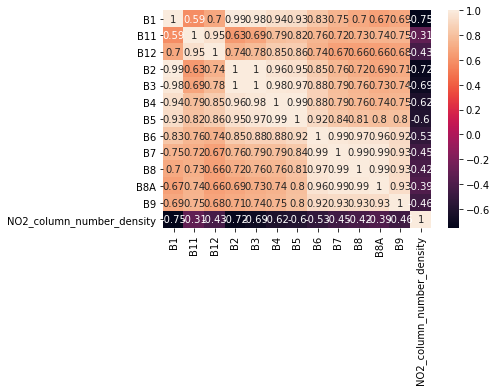

In [155]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

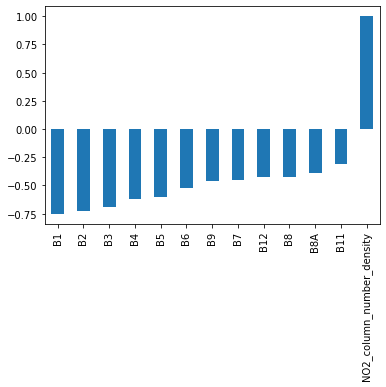

In [156]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

It looks like B1, B2, B3, B4, B10, B11, and sr-aerosol strongly correlate with the NO2 values. It will be good to see how do they perform in a fitted model.

## ! Notes to Toyon !

- Can you run a multivariate regression model for this data, and document p-values?
- Can you run a machine learning model (e.g random forest/GBM) to fit this data? Document the feature importance. You can divide the data into train and test to see how well it performs within the month. 
- Can you test it on a different month (September 2018)? To see the divergence.
- Can you try generating the similar dataset for June 2018 using Sentinel-2 and Sentinel-5P data?
- Side note: we may have to generate additional spatial and temporal values (month, day of week, etc.) in the future to develop more precise models.

In [157]:
dtale.show(df)

In [158]:
df.isnull().sum()

B1                           0
B11                          0
B12                          0
B2                           0
B3                           0
B4                           0
B5                           0
B6                           0
B7                           0
B8                           0
B8A                          0
B9                           0
NO2_column_number_density    0
dtype: int64

In [159]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [160]:
X_sep=df_sep.drop('NO2_column_number_density',axis=1).values
y_sep=df_sep['NO2_column_number_density'].values

X_train_sep, X_test_sep, y_train_sep, y_test_sep = train_test_split(X_sep, y_sep, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train_sep=scaler.fit_transform(X_train_sep)
X_test_sep=scaler.transform(X_test_sep)

In [161]:
type(y)

numpy.ndarray

In [162]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15]
        }
    },
}

In [163]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

,model,best_score,best_params
0,svm,-0.130539,"{'C': 10, 'kernel': 'rbf'}"
1,random_forest,0.687913,{'n_estimators': 15}


In [164]:
#Rainforest Regression
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=15)
model.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=15)

Mean Squared Error = 6.078514110099766e-11
Mean absolute percentage error = 0.06227078554001937


Text(0, 0.5, 'NO2_column_number_density')

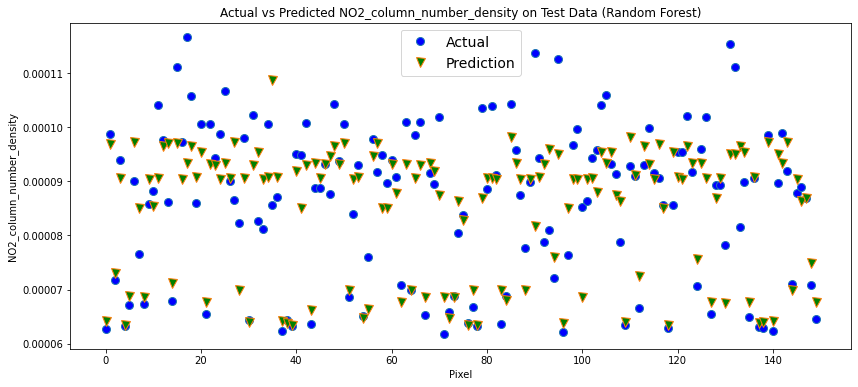

In [165]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 6.664857271232607e-11
Mean absolute percentage error = 0.07297369370362547


Text(0, 0.5, 'NO2_column_number_density')

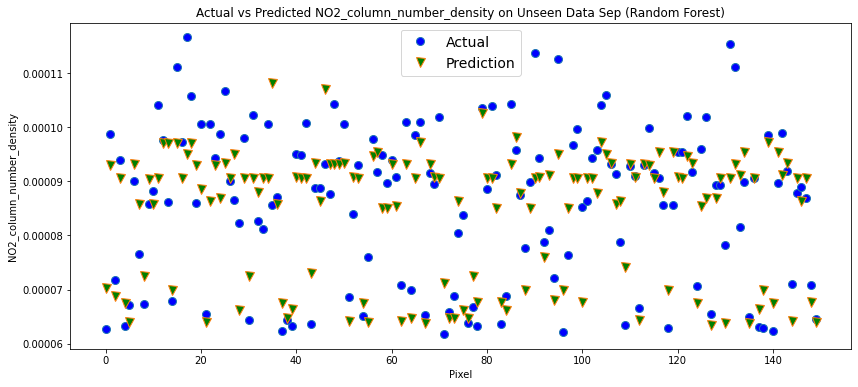

In [166]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [167]:
NO2_column_number_density=df['NO2_column_number_density']

In [168]:
X_all=scaler.transform(X)
all_prediction=model.predict(X_all)

Text(0, 0.5, 'NO2_column_number_density')

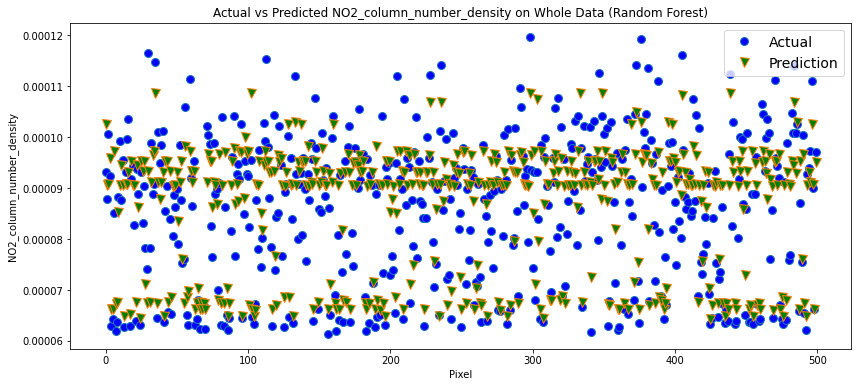

In [169]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [170]:
#X.rename(index={0: "B1", 1: "B10", 2: "B11", 3: "B2",4: "B3", 5: "B4", 6: "B5", 7: "B6", 8: "B7"})

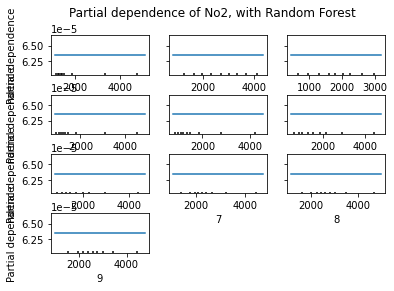

In [171]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5,6,7,8,9])

display.figure_.suptitle('Partial dependence of No2, with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

In [172]:
logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              326.8
Date:                Mon, 21 Jun 2021   Prob (F-statistic):                   8.83e-178
Time:                        16:32:08   Log-Likelihood:                          3221.6
No. Observations:                 350   AIC:                                     -6419.
Df Residuals:                     338   BIC:                                     -6373.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Start Mutlti-OutPut Regression Here! 
## With Target Output  
## y=  ['NO2_column_number_density','tropospheric_NO2_column_number_density']

In [173]:
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density','tropospheric_NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")

In [174]:
ground_truth= image_S2_SR.addBands(image_S5P)

In [175]:
# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 10,
    'numPixels': 500,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [176]:
print(points.size().getInfo())

500


In [177]:
print(points.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-121.63707972816317, 38.31258651670711]}, 'id': '0', 'properties': {'B1': 1355, 'B11': 2306, 'B12': 1396, 'B2': 1134, 'B3': 1193.5, 'B4': 933.5, 'B5': 1356, 'B6': 2883.5, 'B7': 3306, 'B8': 3094.5, 'B8A': 3489, 'B9': 809.5, 'NO2_column_number_density': 9.315050192526542e-05, 'tropospheric_NO2_column_number_density': 3.5703154719780844e-05}}


In [178]:
df = geemap.ee_to_pandas(points)
df

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,NO2_column_number_density,tropospheric_NO2_column_number_density
0,1355.0,2306.0,1396.0,1134.0,1193.5,933.5,1356.0,2883.5,3306.0,3094.5,3489.0,809.5,0.000093,0.000036
1,1162.0,1516.0,888.0,924.0,823.0,748.0,991.0,1561.0,1827.0,1743.0,2010.0,601.0,0.000088,0.000029
2,1445.0,1315.5,1005.5,1106.5,961.0,879.5,996.0,1063.0,1179.0,807.0,1149.5,500.0,0.000101,0.000042
3,1382.0,3739.5,2279.0,1382.5,1481.0,2060.0,2114.0,2466.0,2833.0,2835.5,3295.0,1031.0,0.000092,0.000032
4,4821.5,4091.5,2921.5,4561.0,4237.5,4435.5,4343.5,4448.0,4624.0,4358.5,4707.5,1390.0,0.000063,0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1104.0,1784.5,906.0,907.5,819.5,675.5,1026.5,2144.5,2592.5,2588.0,2961.0,906.0,0.000097,0.000043
496,1448.0,2060.5,1556.0,1257.5,1151.0,1129.5,1325.0,1757.0,1971.5,1592.0,2082.5,549.0,0.000111,0.000056
497,1164.0,1863.0,911.0,907.0,854.0,666.0,1026.0,2067.0,2453.0,2440.0,2765.0,825.0,0.000090,0.000033
498,4391.0,3625.0,2695.0,4151.0,3847.0,4035.0,3988.0,4043.0,4191.5,3908.5,4290.5,1301.0,0.000066,0.000027


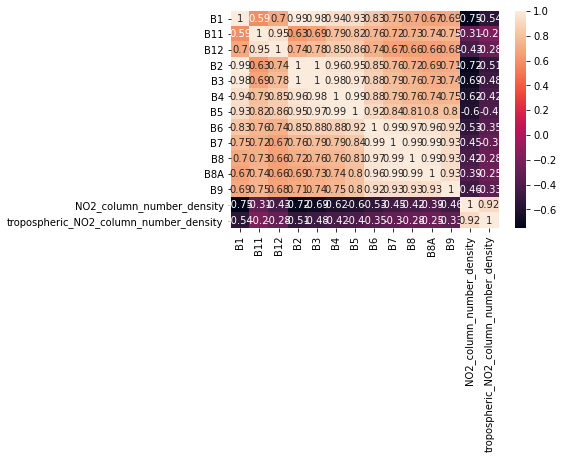

In [179]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

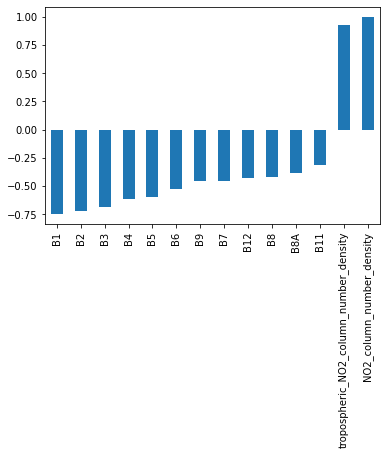

In [180]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

In [181]:
X=df.drop(['NO2_column_number_density','tropospheric_NO2_column_number_density'],axis=1).values
y=df[['NO2_column_number_density','tropospheric_NO2_column_number_density']].values


In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Linear Regression for Multioutput Regression

6.230655510743354e-05
Mean Squared Error = 5.528516921284769e-11
Mean absolute percentage error = 0.06297915487894623
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              326.8
Date:                Mon, 21 Jun 2021   Prob (F-statistic):                   8.83e-178
Time:                        16:33:23   Log-Likelihood:                          3221.6
No. Observations:                 350   AIC:                                     -6419.
Df Residuals:                     338   BIC:                                     -6373.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
  

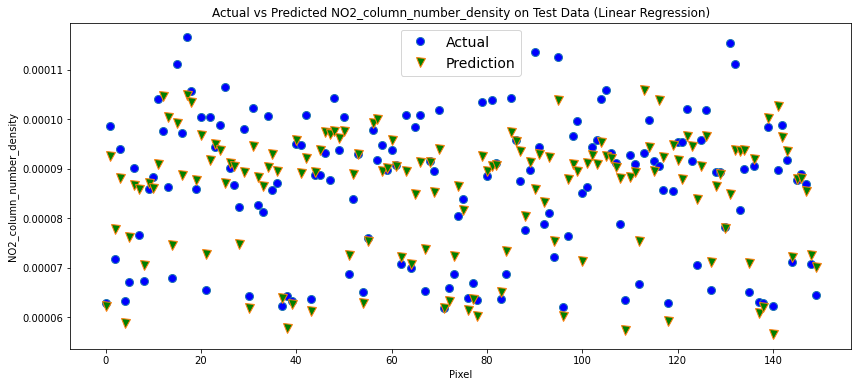

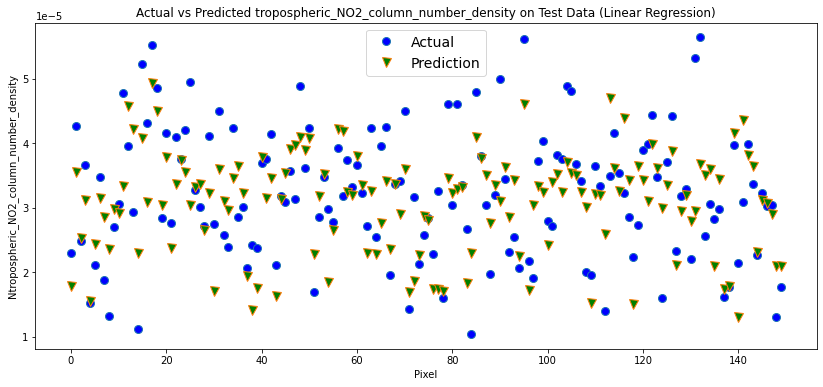

In [183]:
# defining LinearRegression model
model = LinearRegression()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

##
MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,1],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,1],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted tropospheric_NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('Ntropospheric_NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

# k-Nearest Neighbors for Multioutput Regression

6.394797678491772e-05
Mean Squared Error = 7.222640359692225e-11
Mean absolute percentage error = 0.06455722856733753
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              326.8
Date:                Mon, 21 Jun 2021   Prob (F-statistic):                   8.83e-178
Time:                        16:33:24   Log-Likelihood:                          3221.6
No. Observations:                 350   AIC:                                     -6419.
Df Residuals:                     338   BIC:                                     -6373.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
  

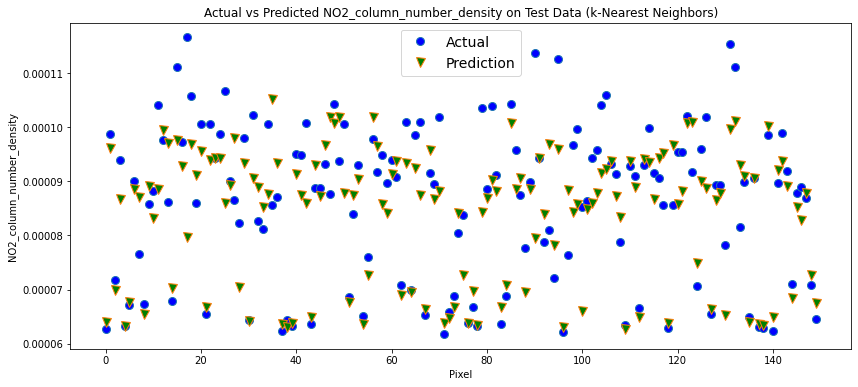

In [184]:
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (k-Nearest Neighbors)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

# Decision Tree for Multioutput Regression

6.195761539859321e-05
Mean Squared Error = 1.1007919518735882e-10
Mean absolute percentage error = 0.08244657492072742
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              326.8
Date:                Mon, 21 Jun 2021   Prob (F-statistic):                   8.83e-178
Time:                        16:33:24   Log-Likelihood:                          3221.6
No. Observations:                 350   AIC:                                     -6419.
Df Residuals:                     338   BIC:                                     -6373.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
 

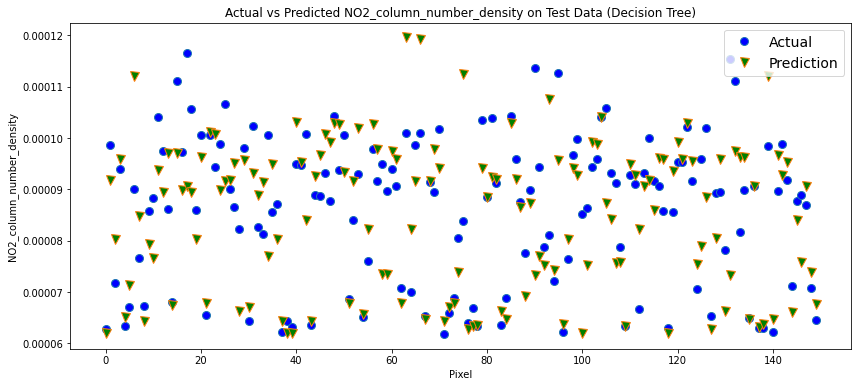

In [185]:
# define model
model = DecisionTreeRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())